In [1]:
from __future__ import division, print_function, absolute_import

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)

    import tensorflow as tf
    import matplotlib.pyplot as plt

    import cv2
    import json
    import os
    import time
    import numpy as np
    import skimage
    import imutils
    import pickle
    import pandas as pd
    from PIL import Image

    from datetime import timedelta
    from imutils import paths
    from skimage import transform
    from scipy.misc import imread, imresize
    from keras.preprocessing.image import img_to_array
    from keras import backend as K
    from keras.preprocessing.image import *

    from sklearn.preprocessing import LabelBinarizer
    from sklearn.model_selection import train_test_split
    from sklearn.utils import shuffle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
pd.options.mode.chained_assignment = None

Using TensorFlow backend.


In [2]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

#from keras import backend as K
#K.tensorflow_backend._get_available_gpus()

In [7]:
# Check if GPU is avaiable
from keras import backend as K



if 'GPU' in K.tensorflow_backend._get_available_gpus()[0]:
    print('Training on GPU!')
else:
    print('Training on CPU, consider using a small number of epochs when training the model')

IndexError: list index out of range

In [8]:
# before you get started, make sure the animals folder is in the same location as this notebook
# below I use the "paths" package to create a list of all the paths contained in our folder

path = 'animals\\'
image_paths = list(paths.list_images(path))

# print dataset size and a sample path from image_paths
print('total dataset size: {}'.format(len(image_paths)))
print('sample path: {}'.format(image_paths[0]))

total dataset size: 30
sample path: animals\cats\cats_00991.jpg


In [9]:
# Warm-up function. Let's get warmed up with all the libraries by writing a function \
# that shows a rancom image from our dataset

def show_random_image(image_paths):
    
    idx = np.random.randint(len(image_paths))
    
    img = cv2.imread(image_paths[idx],1) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    label = image_paths[idx].split(os.path.sep)[-2]
    
    print("category: ", label)
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

In [12]:
# Warm-up function. Let's get warmed up with all the libraries by writing a function \
# that shows a rancom image from our dataset

def show_random_image(image_paths):
    
    idx = np.random.randint(len(image_paths))
    
    img = cv2.imread(image_paths[idx],1) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    label = image_paths[idx].split(os.path.sep)[-2]
    
    print("category: ", label)
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

category:  dogs


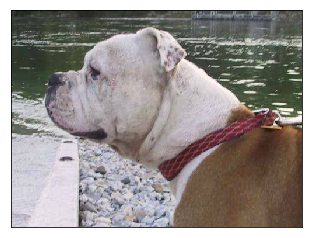

In [13]:
# run the function

show_random_image(image_paths)

In [14]:
# split dev and test set - DO NOT CHANGE THE SEED & TEST SIZE
train_paths, test_paths = train_test_split(image_paths, test_size=0.10, random_state=(19))

In [15]:
train_paths = shuffle(train_paths)

In [16]:
def load_images(image_paths, json_dump=True, verbose=-1):
    
    data=[]
    labels=[]
    
    R = []
    G = []
    B = []
    
    for (i, image_path) in enumerate(image_paths):
        
        image = cv2.imread(image_paths[i],1) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_path.split(os.path.sep)[-2]
        (r, b, g) = cv2.mean(image)[:3]
        
        R.append(r)
        B.append(b)
        G.append(g)
        
        data.append(image)
        labels.append(label)

        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] image loaded {}/{}".format(i + 1,len(image_paths)))

    RGB_dict = {"R": np.mean(R), "G": np.mean(G), "B": np.mean(B)}
    
    if json_dump:
        f = open("RGB_means.json", "w")
        f.write(json.dumps(RGB_dict))
        f.close()
            
        print("[INFO] mean RGB values saved to disk")

    return (np.array(data), np.array(labels), RGB_dict)

In [17]:
#"background_classification_RGB_no_val.json"

In [18]:
def load_images(image_paths, json_dump=True, verbose=-1):
    
    data=[]
    labels=[]
    
    R = []
    G = []
    B = []
    
    for (i, image_path) in enumerate(image_paths):
        
        image = cv2.imread(image_paths[i],1) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_path.split(os.path.sep)[-2]
        (r, b, g) = cv2.mean(image)[:3]
        
        R.append(r)
        B.append(b)
        G.append(g)
        
        data.append(image)
        labels.append(label)

        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] image loaded {}/{}".format(i + 1,len(image_paths)))

    RGB_dict = {"R": np.mean(R), "G": np.mean(G), "B": np.mean(B)}
    
    if json_dump:
        f = open("background_classification_RGB_no_val.json", "w")
        f.write(json.dumps(RGB_dict))
        f.close()
            
        print("[INFO] mean RGB values saved to disk")

    return (np.array(data), np.array(labels), RGB_dict)

In [19]:
# run the function
images, labels, RGB_dict = load_images(train_paths)

[INFO] mean RGB values saved to disk


In [20]:
# the function below resizes the images to even dimensions
# this is more of CS 101 / cv2 problem so I'm just going to give you the code

def resize_images(images, width, height, verbose=-1):
    
    resized_images = []
    
    for i in range(len(images)):
        (h, w) = images[i].shape[:2]
        inter = cv2.INTER_AREA
        dW = 0
        dH = 0
        
        if w < h:
            image = imutils.resize(images[i], width=width, inter=inter)
            dH = int((image.shape[0] - height) / 2.0)
            
        else:
            image = imutils.resize(images[i], height=height, inter=inter)
            dW = int((image.shape[1] - width) / 2.0)

        (h, w) = image.shape[:2]
        image = image[dH:h - dH, dW:w - dW]

        image = cv2.resize(image, (width, height), interpolation=inter)
        resized_images.append(image)
        
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] images resized {}/{}".format(i + 1,len(images)))
        
    return(np.array(resized_images))

In [21]:
# resize the images to 64X64
resized_images = resize_images(images, 64, 64)

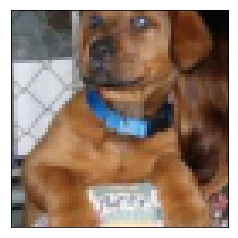

In [22]:
plt.imshow(resized_images[0])
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [23]:
def process_images_RGB(images, RGB_means, verbose=-1):

    processed_images = []

    rMean = RGB_means['R']
    gMean = RGB_means['G']
    bMean = RGB_means['B']
    
    for i in range(len(images)):

        (R, G, B) = cv2.split(images[i].astype("float32"))

        R -= rMean
        G -= gMean
        B -= bMean

        image = cv2.merge([R, G, B])
        processed = img_to_array(image)
        processed_images.append(processed)
        
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] images processed {}/{}".format(i + 1,len(images)))
    
    return(np.array(processed_images))

In [26]:
def process_images_RGB(images, RGB_means, verbose=-1):

    processed_images = []

    rMean = RGB_means['R']
    gMean = RGB_means['G']
    bMean = RGB_means['B']
    
    for i in range(len(images)):

        (R, G, B) = cv2.split(images[i].astype("float32"))

        R -= rMean
        G -= gMean
        B -= bMean

        image = cv2.merge([R, G, B])
        processed = img_to_array(image)
        processed_images.append(processed)
        
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] images processed {}/{}".format(i + 1,len(images)))
    
    return(np.array(processed_images))

In [27]:
processed_images = process_images_RGB(resized_images, RGB_dict, verbose=1000)

In [28]:
train_x, val_x, train_y, val_y = train_test_split(processed_images, labels, test_size=0.10, random_state=(19))

In [29]:
# the function below augment training dataset by creating random variations of our images
# the code itself is trivial and repetitive so I'm just gonna give it to you
# we can go over everything during the next video call


def augment_images(data, data_labels, augementation_factor=1, random_rotation=True, flip_image=True,
                   random_shear=False, random_shift=False, random_zoom=False, verbose=-1):
    
    images = []
    labels = []
    
    # Create a copy of the original images and flip the orginal image horziontally. 
    # This will duplicate the size of our train set.
    
    for idx in range(len(data)):
        images.append(data[idx])
        labels.append(data_labels[idx])
        
        if flip_image:
            images.append(image.flip_axis(data[idx], axis=1))
            labels.append(data_labels[idx])
    
    images, labels = np.array(images), np.array(labels)
            
    augmented_images = []
    augmented_image_labels = []        
    
    for i in range(len(images)):
        
        augmented_images.append(images[i])
        augmented_image_labels.append(labels[i])
        
        for new_img in range(0, augementation_factor):

            if random_rotation:
                augmented_images.append(image.random_rotation(images[i], 35, 
                                        row_axis=0, col_axis=1, channel_axis=2))
                augmented_image_labels.append(labels[i])

            if random_shear:
                augmented_images.append(image.random_shear(images[i], 0.175, 
                                        row_axis=0, col_axis=1, channel_axis=2))
                augmented_image_labels.append(labels[i])

            if random_shift:
                augmented_images.append(image.random_shift(images[i], 0.1, 0.1,
                                        row_axis=0, col_axis=1, channel_axis=2))
                augmented_image_labels.append(labels[i])

            if random_zoom:
                augmented_images.append(image.random_zoom(images[i], (0.8, 1), 
                                        row_axis=0, col_axis=1, channel_axis=2,
                                                        fill_mode = 'nearest'))
                augmented_image_labels.append(labels[i])
                
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] images processed {}/{}".format(i + 1,len(images)))      

    print("[INFO] image aumentation completed.")        
    return np.array(augmented_images), np.array(augmented_image_labels)


In [30]:
train_x_aug, train_y_aug = augment_images(train_x, train_y)

[INFO] image aumentation completed.


In [31]:
print("[INFO] num of images before augmentation: {}".format(len(train_x)))
print("[INFO] num of images after augmentation: {}".format(len(train_x_aug)))

[INFO] num of images before augmentation: 24
[INFO] num of images after augmentation: 96


In [32]:
ind_list = [i for i in range(len(train_x_aug))]
ind_list = shuffle(ind_list)

train_x_aug  = train_x_aug[ind_list, :,:,:]
train_y_aug = train_y_aug[ind_list,]

In [33]:
class_labels = list(np.unique((train_y_aug)))
print('[INFO] class labels: ', class_labels)
#print('[INFO] test set size: ',str(len(val_y)))
#print('[INFO] test dataset: ',val_y)
numClasses = len(class_labels)
height, width, depth = train_x_aug[0].shape

[INFO] class labels:  ['cats', 'dogs', 'pandas']


In [34]:
import collections
collections.Counter(train_y_aug)

Counter({'cats': 28, 'dogs': 36, 'pandas': 32})

In [35]:
from sklearn.preprocessing import LabelBinarizer

# encode class labels
lb = LabelBinarizer()
trainY = lb.fit_transform(train_y_aug)
valY = lb.transform(val_y)

In [39]:
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from build_shallownet import *

[INFO] importing libraries


In [40]:
# model
print("[INFO] building model")
model = ShallowNet.build(width=width, height=height, depth=depth,
                         numClasses=len(class_labels), reg=0.0001, dropoutRate=0.3)
adam = SGD(lr=0.005)#, momentum=0.8, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
print("[INFO] model built")

[INFO] building model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[INFO] model built


In [41]:
print("[INFO] training neural network")
checkpoint = ModelCheckpoint("shallownet_weights.hdf5", monitor="val_loss", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15)


model_hist = model.fit(train_x_aug, trainY, batch_size = 32, epochs = 50, validation_data=(val_x, valY), callbacks=[checkpoint, early_stopping])
print("[INFO] training completed")

[INFO] training neural network
Instructions for updating:
Use tf.cast instead.
Train on 96 samples, validate on 3 samples
Epoch 1/50
96/96 [==============================] - 20s 203ms/step - loss: 1.8769 - acc: 0.3646 - val_loss: 2.6966 - val_acc: 0.3333

Epoch 00001: val_loss improved from inf to 2.69663, saving model to shallownet_weights.hdf5
Epoch 2/50
96/96 [==============================] - 14s 146ms/step - loss: 0.7123 - acc: 0.8229 - val_loss: 2.2535 - val_acc: 0.3333

Epoch 00002: val_loss improved from 2.69663 to 2.25349, saving model to shallownet_weights.hdf5
Epoch 3/50
96/96 [==============================] - 13s 133ms/step - loss: 0.5214 - acc: 0.8958 - val_loss: 2.4125 - val_acc: 0.0000e+00

Epoch 00003: val_loss did not improve from 2.25349
Epoch 4/50
96/96 [==============================] - 14s 141ms/step - loss: 0.3839 - acc: 0.9688 - val_loss: 1.9521 - val_acc: 0.0000e+00

Epoch 00004: val_loss improved from 2.25349 to 1.95207, saving model to shallownet_weights.hdf5

# Testing

In [42]:
from keras.models import load_model

print("[INFO] loading pre-trained network")
model = load_model("shallownet_weights.hdf5")

[INFO] loading pre-trained network


In [43]:
class_labels = ['cats', 'dogs', 'pandas']

In [44]:
def load_data(test_paths, verbose=-1):
    
    data=[]
    labels=[]
    
    for (i, image_path) in enumerate(image_paths):
        
        image = cv2.imread(image_paths[i],1) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_path.split(os.path.sep)[-2]  
        
        data.append(image)
        labels.append(label)
        
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] images loaded {}/{}".format(i + 1,len(image_paths)))

        
    return (np.array(data), np.array(labels))

In [45]:
def process_test_data(images_paths, RGB_dict_path, verbose=10):
    
        with open(RGB_dict_path) as f:
            loaded_RGB_means = json.load(f)
            print("[INFO] JSON file with RGB means loaded")

        # load and process test dataset
        test_data, test_labels = load_data(images_paths, verbose=verbose)
        test_resized_images = resize_images(test_data, 64, 64, verbose=verbose)
        test_processed_images = process_images_RGB(test_resized_images, loaded_RGB_means, verbose=verbose)

        return(test_data, test_processed_images, test_labels)

In [46]:
RGB_dict_path = 'RGB_means.json'

In [48]:
test_data, test_x, test_y = process_test_data(test_paths, RGB_dict_path, verbose=500)

[INFO] JSON file with RGB means loaded


In [49]:
def encode_pred_labels(preds):
    
    predicted_labels = []
    [predicted_labels.append(class_labels[i]) for i in preds]

    return predicted_labels

In [50]:
preds = model.predict(test_x).argmax(axis=1)

predicted_labels = encode_pred_labels(preds)

In [51]:
from sklearn.metrics import classification_report
print("Classification report\n")
print(classification_report(test_y, predicted_labels))

Classification report

              precision    recall  f1-score   support

        cats       0.90      0.90      0.90        10
        dogs       0.83      1.00      0.91        10
      pandas       1.00      0.80      0.89        10

   micro avg       0.90      0.90      0.90        30
   macro avg       0.91      0.90      0.90        30
weighted avg       0.91      0.90      0.90        30



In [52]:
def show_random_images(test_data, predictions, class_labels, n=5):

    for i in range(n):
        # generate random index
        randm_idx = randint(0, len(test_data))

        # display random test image with superimposed predictions
        print("[PREDICTION] ", class_labels[predictions[randm_idx]])
        
        image = cv2.cvtColor(np.array(test_data[randm_idx]), cv2.COLOR_BGR2RGB)
        cv2.putText(image, "Pred.: {}".format(class_labels[predictions[randm_idx]]),
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.imshow("Image", image)
        cv2.waitKey(0)

In [ ]:
from random import randint

In [ ]:
show_random_images(test_data, preds, class_labels, n=5)

In [ ]:
# visualize model architecture and save image
import os
os.environ["PATH"] += os.pathsep + 'C:\Anaconda3\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz'

from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
"""
#shuffle test data

ind_list = [i for i in range(len(test_data))]
ind_list = shuffle(ind_list)

test_data  = test_data[ind_list]
test_y = test_y[ind_list]
preds = preds[ind_list]
"""

In [ ]:
"""
# display predictions and ground truth

for (image, true_y, y_hat) in zip(test_data[200:205], test_y[200:205], preds[200:205]):
    
    print("predicted: ", class_labels[y_hat])
    print("actual: ", true_y)
    
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
"""